## Semantic Segmentation
- Semantic Segmentation은 사진이 주어졌을 때 사진 내 각 픽셀을 카테고리로 분류하는 task이다.
- 영상 내의 컨텐츠를 이해하고 편집할 때 사용이 된다. (의료 영상, 자율주행 등...)

---
## 1. Fully Convolutional Networks (FCN)
- 첫 end-to-end Semantic segmentation 뉴럴 모델이다.
- 테스트할 때, 임의의 사이즈의 영상을 입력으로 사용해도 문제가 없는 호환성 좋은 모델이다.

### FCN 연산 방법
- AlexNet에서는 flatten을 통해 긴 벡터형태를 만들고, FC layer의 input으로 사용했다.
- 하지만 이는 영상의 공간정보를 고려하지 않는 방법이다. (하나의 벡터로 섞여버림)


- 어떻게 각 위치마다 classification을 할 수 있도록 하지?
- 각 위치마다 채널축으로 flatten을 하는 것임.
- 즉, 각각의 위치마다 벡터가 하나씩 나오게 된다.

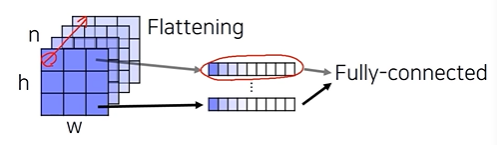

- 1x1 convolution layer가 이와 동일한 연산이다.
- 채널축으로 1x1 conv kernel이 FC layer의 하나의 weight column이라고 볼 수 있다.
- filter 개수만큼 통과를 시키면, 각 위치마다 fc layer를 별도로 돌려서 각각의 위치에 결과값을 채우는 것과 동일해진다. 

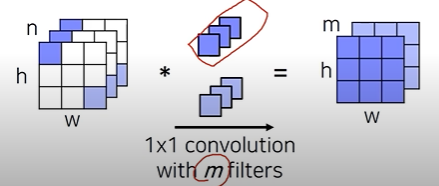

### fully connected layer는 1x1 conv layer으로 구현이 가능해졌다.
- fc layer를 conv layer로 대체하게 되었고,
- 어떤 입력 사이즈에도 대응이 가능해짐.


- **다만, 문제점은 semantic segmentation 모델은 굉장히 작은 score map를 얻게 된다.**
- **input이 커도 output score map이 작아진다는 것.**
- stride나 pooling layer로 인해서 최종 activation map이 저해상도가 된다.


- 이러한 저해상도 문제를 회피하기 위해, upsampling을 도입하게 된다.

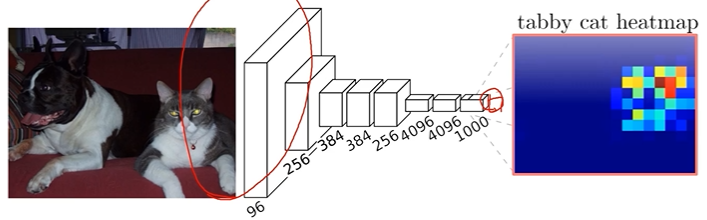

### Upsampling
- FCN에서는 작은 activation map을 원래 input 사이즈에 맞추기 위해서, upsampling을 사용한다.
- 일단 작게 만들어서 receptive field를 최대한 키우는게 성능에 좋고, 그 후에 upsampling을 통해 resolution을 맞춰주게 된다.


- 방법 1 : `Transposed convolution`
- 방법 2 : `Upsample and convolution`

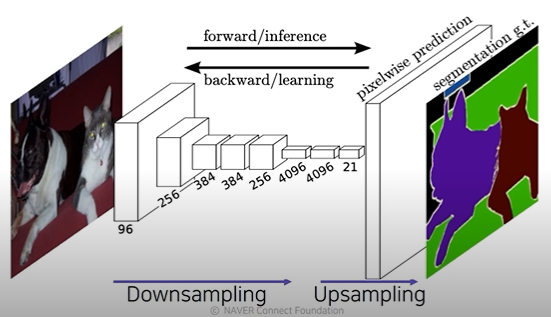

#### `Transposed convolution`
- checkerboard artifacts 문제가 발생한다.
- 일정 부분이 계속 중첩되는 것
- 중첩이 생기지 않도록 튜닝을 해줘야 한다.(커널과 스트라이드를 잘 맞춰야 함)

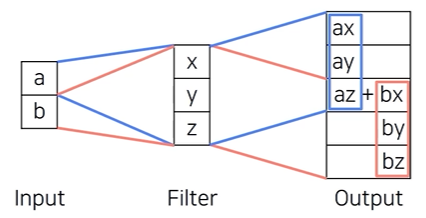

#### `Upsample and convolution`
- Transposed convolution의 문제를 해결하면서 성능을 올리기 위한 대안으로 upsampling과 convolution을 같이 사용하게 된다.
- 중첩 문제를 없애고 골고루 영향을 받을 수 있게 함.


- interpolation을 먼저 적용한다. (Nearest-neighbor, Bilinear 등..)
- 여기까지는 해상도만 키우고, 학습 가능한 파라미터가 없다.
- 이제 convolution을 적용해서 학습 가능하게 함.

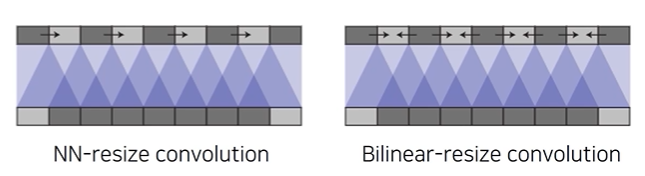

### FCN adding skip connections
- 낮은 레이어쪽(conv1, conv2 처럼 앞 부분)은 receptive field size가 작기 때문에, 국지적이고 작은 디테일을 보기 때문에 민감하다.
- 높은 레이어쪽(conv6, conv7 ..) 해상도가 많이 낮아지지만, receptive field size가 크기 때문에 영상의 전반적인 의미와 글로벌한 정보를 포함하게 된다.


- 하지만 Semantic Segmentation은 두 정보 모두 필요하다.
- 이를 위해 높은 레이어쪽의 activation map을 Upsampling을 통해 해상도를 높이고,
- 이에 맞춰서 다른 중간층의 activation map도 upsampling을 해서 가져온다.
- 그리고 이들을 concat해서 최종 출력을 만들게 된다.
- FCN-8s : pool3 + pool4 + conv7 다 합친 모델

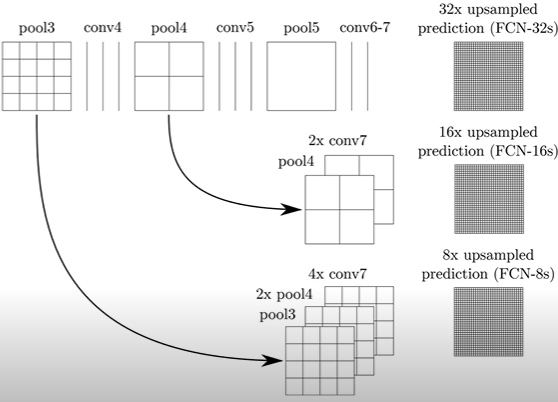

---
## 2. U-Net
- Segmentation에서 breakthrough를 이뤄낸 모델
- 마찬가지로 FCN을 사용한다.
- 낮은 층의 feature와 높은 층의 feature를 이전보다 더 잘 결합함. (물론 skip connection을 사용함)

### Contracting path
- receptive field를 크게 확보하기 위해, 해상도를 낮추고 채널을 늘림.
- 이를 반복해서 작은 activation map을 구함. (여기에 영상의 전반적인 정보가 잘 포함되어 있다고 가정함)
- 여기까지는 사실 일반적인 CNN과 동일하다고 볼 수 있다.

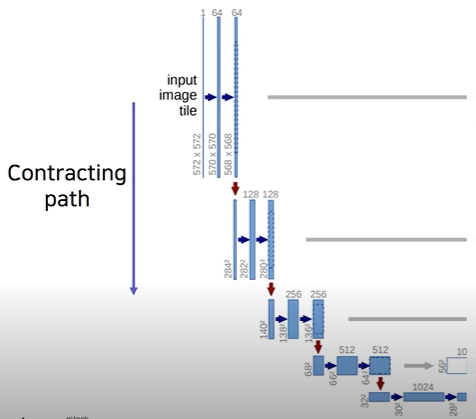

### Expanding path
- Upsampling 부분
- 점진적으로 activation map의 해상도를 올려주고 채널은 줄어든다.
- 여기서 Contracting path와 대칭으로 대응되는 layer와 concat을 하게 된다. (skip connection)



- 즉, 낮은 층의(contracting 부분) activation map을 합쳐서 사용하는 것
- 낮은 레이어에서 전달된 feature = localized information
- 경계선이나 공간적으로 중요한 정보를 뒤쪽 레이어에 바로 전달하는 역할

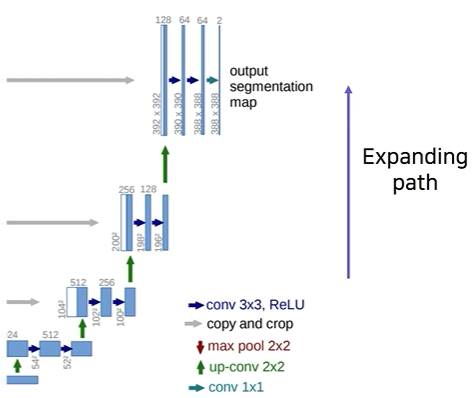

### U-Net 주의점
- U-net은 Downsampling과 Upsampling이 빈번하게 일어나는 모델이다.
- 만약 input size가 홀수면 사이즈가 줄어들고 증가하면서, 원래 입력과 해상도 차이가 나게 된다.
- input size가 7일 때, downsample로 3이 되고, 다시 upsample을 하면 6이 되기 때문

---
## 3. DeepLab
- 역시나 중요한 모델이다.
- 두가지 핵심이 있다
    - `CRF` 
    - `Atrous Convolution` = `Dilated Convolution`

### CRF (Conditional Random Fields)
- 후처리에 사용되는 기술
- 픽셀과 픽셀 사이의 관계를 이어준다.
- 경계를 잘 찾을 수 있게 모델링 해준다.

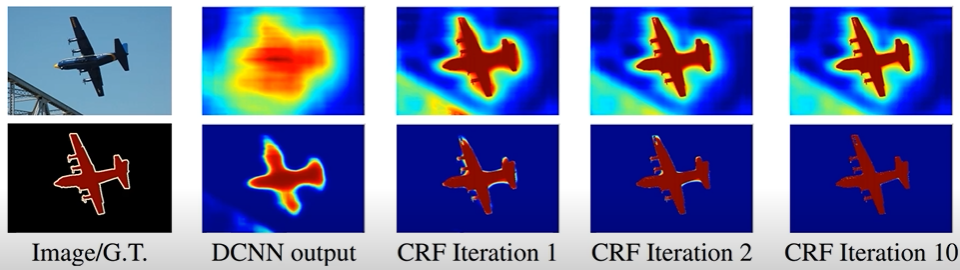

### Atrous Convolution (Dilated Convolution)
- convolution kernel 사이에 일정 공간을 넣어준다. (Dilation factor)
- 실제 convolution kernel 보다 넓은 영역을 고려할 수 있지만, 파라미터 수는 늘어나지 않는다.
- receptive fields 사이즈가 크게 증가하는 효과를 얻음.

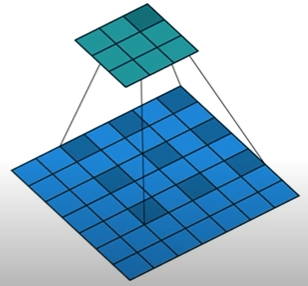